# Лабораторная №4 - Построение многослойных нейронных сетей используя tensorflow

В предыдущей работе были разобраны базовые элементы библиотеки tensorflow и построен простейший нейрон. При построение массивных нейронных сетей используется огромное количество нейронов и связей между ними. Tensorflow содержит множество высокоуровневых асбтракций, которые позволяют в кротчайшие сроки создавать сложные глубинные сети. В данной лабораторной работы будет рассмотрено построение многослойной сети, используя слои нейронов, которые предоставляет библиотека tensorflow

In [95]:
# подключение нужных библиотек
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer

В качестве исходных данных будет использоваться данные о титанике, описанные в первой лабораторной работе. Однако в исходном виде обучение даст плохие результаты, поэтому необходимо его преобразовать. tensorflow содержит обширное встроенные возможности трансформации данных, однако для простоты будет использоваться pandas и sklearn

In [96]:
# Загрузка дата сета
data = pd.read_csv("datasets/titanic_train.csv")

Замена пола на boolean переменную, а так уже удаление вторичных столбцов

In [97]:
genders = {"male": 1, "female": 0}
data["Sex"] = data["Sex"].apply(lambda s: genders.get(s))
data = data.drop(["PassengerId","Name", "Ticket", "Fare", "Cabin", "Embarked"],axis=1)

Рассмотрим колонку Pclass. 

In [98]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


Данная колонка содержит конечное число различных идентификатор(1-3), поэтому для повышения качества обучения стоит использовать one hot encoding

In [99]:
data = pd.concat([data, pd.get_dummies(data["Pclass"], prefix="Pclass")], axis=1)
data = data.drop("Pclass", axis=1)
data.head()

,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,0,0,1
1,1,0,38.0,1,0,1,0,0
2,1,0,26.0,0,0,0,0,1
3,1,0,35.0,1,0,1,0,0
4,0,1,35.0,0,0,0,0,1


In [100]:
#замена пустых значений 
# Для этого используется Imputer, который по умолчанию заменяет недастающие значения 
# средними значениями по выборке
nan_columns = ["Age", "SibSp", "Parch"]

for column in nan_columns:
    imputer=Imputer()
    data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))

In [101]:
# приведение типов для всей выборки
data = data.astype(float).fillna(0)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null float64
Sex         891 non-null float64
Age         891 non-null float64
SibSp       891 non-null float64
Parch       891 non-null float64
Pclass_1    891 non-null float64
Pclass_2    891 non-null float64
Pclass_3    891 non-null float64
dtypes: float64(8)
memory usage: 55.8 KB


Как видно все типы теперь float. Так же необходимо нормализовать данные. Единственный столбец, который не нормализован это Age. 

In [103]:
scaler = MinMaxScaler()
data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))

In [104]:
data.head(5)

,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
0,0.0,1.0,0.271174,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.472229,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.321438,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.434531,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.434531,0.0,0.0,0.0,0.0,1.0


Теперь все данные нормализованы, необходимо разбить исходные данных на обучающую и тестовую выборку. Для этого удобно воспользоваться train_test_split из sklearn

In [105]:
train, test = train_test_split(data, test_size=0.2)

In [106]:
# очистка графа и создание сессии
tf.reset_default_graph()
sess = tf.InteractiveSession()

В предыдущей лабораторной работе использовалась подача данных при инициализации вычислений. Однако такой метод недостаточно производительный. Поэтому tensorflow имеет data api. Оно содержит средства для загрузки данных из различных источников, преобразования и так далее. Основным элементов является dataset. Его можно создать множеством способов, но самыми распространёнными является память и файлы. В нашем случае данные находятся в памяти. Для инициализации датасета из памяти используется функция from_tensor_slices, которая может принимать любые объекты. Если оно примет tensor - будут использоваться данные от него. Если будет передан какой-то объект - будет создан узел tf.constant, который будет содержать все данные.

Помимо этого, tf предоставляет методы для манипулирования данными. repeat - повторяет все данные в датасете переданное количество раз. shuffle - перемешивает данные, в качестве параметра принимает размер буфера для перемешивания. batch - объединяет n записей в одну. Для примера повторим выборку 600 раз, что эквивалентно 600 циклам обучения, перемешаем и в качестве одного пакета возьмём 1000 строк. Создадим датасет для обучающей и тестовой выборки

In [116]:
train_ds = tf.data.Dataset.from_tensor_slices((train.drop("Survived",axis=1),train["Survived"]))
train_ds = train_ds.repeat(600).shuffle(10000).batch(1000)

test_ds = tf.data.Dataset.from_tensor_slices((test.drop("Survived",axis=1),test["Survived"]))
test_ds = test_ds.batch(10000)

In [117]:
train_ds

<BatchDataset shapes: ((?, 7), (?,)), types: (tf.float64, tf.float64)>

Как видно, каждая запись в датасете содержит пакет из строк, где каждая строка представляет собой вектор из 7 значений исходных данных

Для обучения на основе датасета используются итераторы. tf.data.Iteratro является основным
способом извлечения данных из него. iterator.get_next извлекает следующий элемент датасета 
переводит итератор на следующий элемент.Когда элементов в датасете больше нет, появляется исключение tf.errors.OutOfRangeError.Существует несколько типов итераторов:
* one shot iterator - проходит по выборке только один раз, не можем быть повторно использован, но не требует инициализации во время запуска вычислений
* initializable - требует инициализации и используется, когда необходимо параметризировать исходный датасет. Например, передать размер датасета с помощью feed_dict
* reinitializable - так же требует инициализации, но в качестве параметра принимает датасет, из которого будут извлекаться значения. Таким образом можно использовать разные датасеты, созданные ранее. Но при этом, структура датасета не должна изменяться, поэтому при создании итератора необходимо указать его структуру

In [118]:
# создание reinitializable итератора
iterator = tf.data.Iterator.from_structure(train_ds.output_types,
                                           train_ds.output_shapes)

# так же создадим операции инициализации здесь, для удобства
# они пригодятся позже
train_init = iterator.make_initializer(train_ds)
valid_init = iterator.make_initializer(test_ds)
# излвечение следующих элементов выборки. Мы используем пакеты, поэтому каждое 
#features содержит 1000 векторов из 7 значений, а labels - 1000 значений, 
# которые характеризуют выживание
features , labels = iterator.get_next()

labels = tf.reshape(labels,[tf.shape(labels)[0],1])

Далее необходимо сформировать нейронную сеть. В данной лабораторной работе будут использоваться готовые слои из tensorflow. Таковыми являются:
* tf.layers.dense - полносвязный слой нейронов.
* tf.nn.relu - работает как функция активации relu для слоя нейронов

Двумя основными параметрами при создания слоёв являются входные параметры и количество выходов. 
Ниже приведён пример создание нейронной сети из 4х слоёв с одним выходом и входным вектором данных размерностью 3
```
x = tf.layer.dense(tf.float32, shape=3)
layer_1 = tf.layers.dense(x,3)
layer_2 = tf.layers.dense(layer_1,4)
layer_3 = tf.layers.dense(layer_2,3)
y = tf.layers.dense(layer_3,1)
```
В таком случае будет создана следующая нейронная сеть
![asda](./images/lab4_nn.png "Title")

Однако подобная простейшая сеть даст плохой результат для выборки, рассматриваемой в данной лабораторной работе. Поэтому введём дополнительные слои relu и batch normalization

In [119]:
hidden_size = 256
keep_prob = tf.placeholder(tf.float64)
is_training=tf.Variable(True,dtype=tf.bool)

input_l = tf.layers.dense(features,hidden_size)
normalization_layer = tf.layers.batch_normalization(input_l)
relu = tf.nn.relu(normalization_layer)
layer_out = tf.layers.dense(relu,1)

In [120]:
# в качестве функции ошибки при пакетной обработке используется cross entropy. 
# По-сути эта функции вычисляет разницу между векторов предсказанных значений
# и вектором верных значений
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=layer_out, labels=labels)
loss = tf.reduce_mean(loss)

# так же добавим вычисление точности. В отличии от функции потерь, в этом случае 
# данные округляются
predicted = tf.nn.sigmoid(layer_out)
correct_pred = tf.equal(tf.round(predicted), labels)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

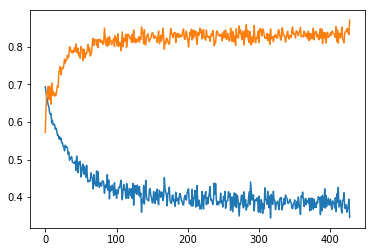

In [121]:
#инициализация всех весов в графе
tf.global_variables_initializer().run()
losses = []
accs = []
# инициализация итератора на тестовом датасете
sess.run(train_init)
# пока итератор не дойдёт до конца датасета, проводим обучение
# датасет имеет repeat(600), что эквивалентно 600 циклам обучения и нет 
# необходимости обнулять итератор
# каждую итерацию получаея потери и точность
while True :
    try:
        acc , los , _ = sess.run([accuracy,loss, optimizer ], feed_dict = {is_training : True})
        losses.append(los)
        accs.append(acc)
    except tf.errors.OutOfRangeError:
         break;
            
plt.plot(range(len(losses)),losses)
plt.plot(range(len(accs)),accs)

Как видно, после 200 пакета ошибка уменьшается незначительно. Таким образом, точность обученной нейронной сети составляет ~80%. Хотя подобная оценка является весьма поверхностной

In [122]:
# инициализация итератора на тестовой выборке, проверяя качество обучения сети
sess.run(valid_init)
accuracy = sess.run([accuracy], feed_dict = {is_training : False})
accuracy

[0.79888266]

## Задание на лабораторную
Файлы с исходными данными находятся по пути *Datasets/classification/v<номер варианта>.csv*

| Вариант | Целевая переменная | Краткое описание | Источник
|-------|------------|----------------------------|-------------------|
|1|y|Предсказать, воспользуется ли клиент временным депозитом.|https://archive.ics.uci.edu/ml/datasets/bank+marketing
|2|bad|Предсказать значение переменной BAD, показывающей что клиент банка не выполнит свои обязательства(например не выплатит кредит).|https://www.kaggle.com/ajay1735/hmeq-data/data
|3|churn|Предсказать что клинет оператора(столбец churn) откажется от его услуг|https://www.kaggle.com/becksddf/churn-in-telecoms-dataset/data
|4|RainTomorrow|Предсказать, будет ли завтра дождь(Столбец RainTomorrow), на основе данные за текущий день |https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
|5|sol|Пресказать, зарабатывает ли человек более 50k долларов в год|https://archive.ics.uci.edu/ml/datasets/Adult
|6|acceptable|Предсказать, что качество машины в удовлетворительном состоянии( столбец acceptable)|https://archive.ics.uci.edu/ml/datasets/Car+Evaluation
|7|Severity| Предсказать тип образование ( столбец Severity, 1 - злокачественная) |https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass
|8|dicision|Определить, готов ли пациент для выписки из больницы( столбец dicision = 1)|https://archive.ics.uci.edu/ml/datasets/Post-Operative+Patient
|9|edible|Определить, является ли гриб съедобным по его внешним признакам( столбец edible)|https://archive.ics.uci.edu/ml/datasets/Mushroom
|10|class|Предсказать банкротство на основе рисков( столбец class)|https://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy
|11|class|Определить каким типом посадки необходимо воспользоваться : автоматическая или ручная ( столбец class)|https://archive.ics.uci.edu/ml/datasets/Shuttle+Landing+Control
|12|absence|Определить наличие болезни сердца ( столбец absence )|https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29
|13|target|Используя данные о сессии браузера, определить является пользователем Элис Целевой признак target – факт того, что сессия принадлжит Элис (то есть что именно Элис ходила по всем этим сайтам)|https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking
|14|survive|Определить, проживёт ли пациент более 5 лет после проведения операции|https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival
|15|isAlive|Определить, выживет ли персонаж игры престолов(колонка isAlive)|https://www.kaggle.com/mylesoneill/game-of-thrones/data